"""
===================================================
MLDL COURSE PROJECT — FLOOD SEGMENTATION
===================================================

Project Overview:
    Floods are among the most impactful natural disasters, causing widespread
    damage to communities, infrastructure, and the environment. Rapid and accurate
    flood extent mapping is essential for emergency response, evacuation planning,
    and post-disaster assessment. Traditional manual mapping is slow, subjective,
    and not scalable to the large volume of aerial or satellite imagery available
    during disaster events.

    This project develops a deep learning–based semantic segmentation model that
    identifies flooded regions and other land-cover categories at pixel-level
    precision. Using a U-Net convolutional neural network (CNN), the system
    produces detailed segmentation masks that support faster and more reliable
    flood analysis for disaster management.

Dataset:
    The dataset consists of:
        • RGB aerial images located at: "images/<scene_id>/*.jpg"
        • RGB-encoded semantic masks located at: "annotations/<scene_id>/*.png"

    Each mask pixel represents one of six semantic classes encoded using unique
    RGB values. These classes include flooded areas, water bodies, vegetation,
    infrastructure, and other land-cover regions.

Model Approach:
    • Primary Model:
        U-Net CNN architecture for semantic segmentation, producing six-class
        pixel predictions.
    • Baseline Model:
        A majority-class predictor that assigns the most frequent class to all
        pixels, serving as a simple reference for evaluating U-Net performance.

Evaluation Metrics:
    • Pixel Accuracy — percentage of correctly labeled pixels
    • Mean Intersection-over-Union (mIoU) — measures overlap quality across classes
    • Precision and Recall — per-class evaluation, especially helpful for minority
      or structurally small classes

Notes:
    These metrics collectively evaluate segmentation quality, class balance, and
    the model’s ability to distinguish between multiple land-cover categories.
"""


In [18]:
# ============================================================
# STEP 0 — SETUP & EXTRACT DATA
# ============================================================
!apt-get install -y unrar

import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)

# Path to the uploaded RAR file
RAR_PATH = "/content/Dataset.rar"   # <--- THIS IS YOUR FILE
EXTRACT_TO = "/content"             # Extract directly to /content/

# Extract ONLY if Dataset/ does not exist
if not os.path.exists("/content/Dataset"):
    print("Extracting dataset.rar ...")
    !unrar x "{RAR_PATH}" "/content/"
else:
    print("Dataset already extracted.")

# After extraction, the correct dataset root is:
ROOT_DIR = "/content/Dataset/FloodNet"
IMG_DIR = os.path.join(ROOT_DIR, "images")
MASK_DIR = os.path.join(ROOT_DIR, "annotations")

print("ROOT_DIR:", ROOT_DIR)
print("Images directory exists:", os.path.exists(IMG_DIR))
print("Masks directory exists:", os.path.exists(MASK_DIR))

if not os.path.exists(IMG_DIR) or not os.path.exists(MASK_DIR):
    raise RuntimeError(" Dataset folders not found — check extraction paths!")
else:
    print(" Dataset structure successfully detected.")

# ============================================================
# CREATE RESULTS FOLDERS FOR SAVING OUTPUT IMAGES & GRAPHS
# ============================================================

RESULTS_DIR = "/content/MLDL_FloodDetection/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

print("All results will be saved to:", RESULTS_DIR)




Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Dataset already extracted.
ROOT_DIR: /content/Dataset/FloodNet
Images directory exists: True
Masks directory exists: True
 Dataset structure successfully detected.
Results will be saved to: /content/MLDL_FloodDetection/results
Prediction samples will be saved to: /content/MLDL_FloodDetection/results/prediction_samples


In [19]:
# ============================================================
# STEP 1 — COLOR PALETTE (FROM MASKS)  [Week 1: Dataset]
# ============================================================
# These 6 RGB colors come from your "Unique RGB colors" analysis:
color_palette = [
    (61, 61, 245),
    (250, 50, 83),
    (255, 96, 55),
    (51, 221, 255),
    (102, 255, 102),
    (92, 179, 162),
]

color_to_class = {c: i for i, c in enumerate(color_palette)}
num_classes = len(color_palette)

print("\nColor → Class mapping:")
for c, i in color_to_class.items():
    print(f"  {c} -> class {i}")
print("Total classes:", num_classes)


Color → Class mapping:
  (61, 61, 245) -> class 0
  (250, 50, 83) -> class 1
  (255, 96, 55) -> class 2
  (51, 221, 255) -> class 3
  (102, 255, 102) -> class 4
  (92, 179, 162) -> class 5
Total classes: 6


In [20]:
# ============================================================
# STEP 2 — DATASET CLASS  [Used in all weeks]
# ============================================================
class FloodSegDataset(Dataset):
    """
    Semantic segmentation dataset for flood imagery.

    - root/images/<scene_id>/*.jpg
    - root/annotations/<scene_id>/*.png

    Each mask is RGB-colored; we map colors -> class IDs [0..5].
    """

    def __init__(self, root, transform=None, img_size=(256, 256)):
        self.img_root = os.path.join(root, "images")
        self.mask_root = os.path.join(root, "annotations")
        self.transform = transform
        self.img_size = img_size
        self.samples = []

        # Walk through scene folders
        for scene in os.listdir(self.img_root):
            img_scene = os.path.join(self.img_root, scene)
            mask_scene = os.path.join(self.mask_root, scene)

            if not os.path.isdir(img_scene):
                continue

            for fname in os.listdir(img_scene):
                if fname.lower().endswith(".jpg"):
                    base = fname[:-4]
                    img_path = os.path.join(img_scene, fname)
                    mask_path = os.path.join(mask_scene, base + ".png")

                    if os.path.exists(mask_path):
                        self.samples.append((img_path, mask_path))

        print("Total image-mask pairs:", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        img = Image.open(img_path).convert("RGB")
        mask_img = Image.open(mask_path).convert("RGB")

        # Resize both
        img = img.resize(self.img_size)
        mask_img = mask_img.resize(self.img_size, Image.NEAREST)

        # Convert RGB mask -> class mask
        mask_arr = np.array(mask_img)
        h, w, _ = mask_arr.shape
        mask_class = np.zeros((h, w), dtype=np.int64)

        for color, cid in color_to_class.items():
            mask_class[(mask_arr == color).all(axis=2)] = cid

        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        mask_tensor = torch.tensor(mask_class, dtype=torch.long)

        return img, mask_tensor

In [21]:
# ============================================================
# STEP 3 — CREATE DATASET & DATALOADERS
#            [Week 2-3: Preprocessing + EDA]
# ============================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

full_dataset = FloodSegDataset(ROOT_DIR, transform=transform, img_size=(256,256))

# Train/val split (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=4, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

Total image-mask pairs: 3574
Train samples: 2859, Val samples: 715



Approximate class pixel distribution:
Class 0: 3520909 pixels (26.86%)
Class 1: 4370490 pixels (33.34%)
Class 2: 1133488 pixels (8.65%)
Class 3: 4008621 pixels (30.58%)
Class 4: 3535 pixels (0.03%)
Class 5: 70157 pixels (0.54%)


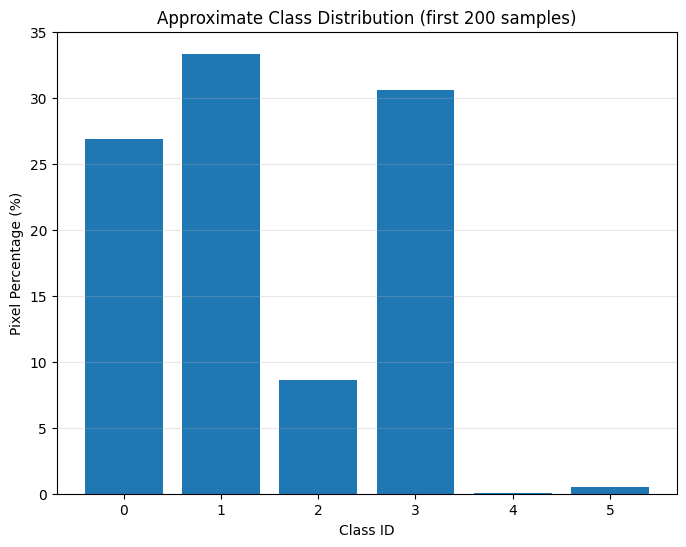

Saved class distribution plot -> /content/MLDL_FloodDetection/results/class_distribution.png


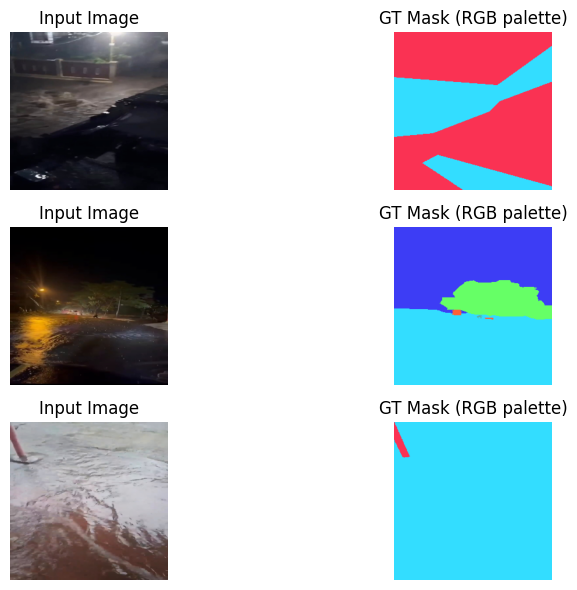

Saved sample input+GT masks -> /content/MLDL_FloodDetection/results/sample_input_gt_pairs.png


In [22]:
# ============================================================
# STEP 4 — EDA & CLASS DISTRIBUTION  [Week 2-3: EDA]
# ============================================================
def compute_class_distribution(dataset, max_samples=200):
    """
    Compute approximate distribution of classes in masks
    using up to max_samples from dataset.
    """
    counts = np.zeros(num_classes, dtype=np.int64)
    n = min(max_samples, len(dataset))

    for i in range(n):
        _, mask = dataset[i]   # mask is (H,W)
        mask_np = mask.numpy().flatten()
        for c in range(num_classes):
            counts[c] += np.sum(mask_np == c)

    return counts

# Compute distribution
class_counts = compute_class_distribution(full_dataset, max_samples=200)
class_props = class_counts / class_counts.sum()

print("\nApproximate class pixel distribution:")
for c, cnt in enumerate(class_counts):
    print(f"Class {c}: {cnt} pixels ({class_props[c] * 100:.2f}%)")

# ---------------------------
# SAVE BAR PLOT
# ---------------------------
plt.figure(figsize=(8, 6))
plt.bar(range(num_classes), class_props * 100)
plt.xlabel("Class ID")
plt.ylabel("Pixel Percentage (%)")
plt.title("Approximate Class Distribution (first 200 samples)")
plt.grid(axis="y", alpha=0.3)

dist_plot_path = os.path.join(RESULTS_DIR, "class_distribution.png")
plt.savefig(dist_plot_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved class distribution plot ->", dist_plot_path)


# ============================================================
# SHOW & SAVE SAMPLE INPUT IMAGES + MASKS
# ============================================================
def decode_mask(mask_class):
    """Convert class mask (H,W) -> RGB mask (H,W,3)."""
    h, w = mask_class.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for color, cid in color_to_class.items():
        rgb[mask_class == cid] = color
    return rgb

imgs, masks = next(iter(train_loader))
imgs_np = imgs.numpy().transpose(0, 2, 3, 1)  # (B,H,W,C)
masks_np = masks.numpy()

fig = plt.figure(figsize=(10, 6))

for i in range(min(3, imgs_np.shape[0])):
    # Input image
    plt.subplot(3, 2, 2*i + 1)
    img_show = (imgs_np[i] * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])
    img_show = np.clip(img_show, 0, 1)
    plt.imshow(img_show)
    plt.title("Input Image")
    plt.axis("off")

    # Ground truth mask
    plt.subplot(3, 2, 2*i + 2)
    plt.imshow(decode_mask(masks_np[i]))
    plt.title("GT Mask (RGB palette)")
    plt.axis("off")

plt.tight_layout()

sample_path = os.path.join(RESULTS_DIR, "sample_input_gt_pairs.png")
plt.savefig(sample_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved sample input+GT masks ->", sample_path)


In [23]:
# ============================================================
# STEP 5 — U-NET MODEL  [Week 2-3: Initial Model]
# ============================================================
class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )

        self.down1 = CBR(3, 64)
        self.down2 = CBR(64, 128)
        self.down3 = CBR(128, 256)
        self.down4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)

        self.mid = CBR(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)

        self.final = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        e1 = self.down1(x)
        e2 = self.down2(self.pool(e1))
        e3 = self.down3(self.pool(e2))
        e4 = self.down4(self.pool(e3))

        mid = self.mid(self.pool(e4))

        d4 = self.up4(mid)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.final(d1)

In [24]:
# ============================================================
# STEP 6 — TRAINING SETUP + METRICS  [Week 2-3 & Week 4-5]
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nUsing device:", device)

model = UNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def pixel_accuracy(pred, target):
    """
    pred, target: (B,H,W)
    """
    correct = (pred == target).sum().item()
    total = target.numel()
    return correct / total

def iou_score(pred, target, num_classes):
    """
    Mean IoU over num_classes.
    pred, target: (B,H,W)
    """
    ious = []
    for c in range(num_classes):
        pred_c = (pred == c)
        tgt_c  = (target == c)
        intersection = (pred_c & tgt_c).sum().item()
        union = (pred_c | tgt_c).sum().item()
        if union == 0:
            continue
        ious.append(intersection / union)
    if len(ious) == 0:
        return 0.0
    return np.mean(ious)


Using device: cuda



Epoch 1/10
Train Loss: 0.9766
Val Loss:   0.7465
Val Acc:    74.57%
Val mIoU:   0.3692

Epoch 2/10
Train Loss: 0.6982
Val Loss:   0.5877
Val Acc:    79.90%
Val mIoU:   0.4337

Epoch 3/10
Train Loss: 0.5745
Val Loss:   0.4732
Val Acc:    84.19%
Val mIoU:   0.5190

Epoch 4/10
Train Loss: 0.4716
Val Loss:   0.3683
Val Acc:    87.89%
Val mIoU:   0.5739

Epoch 5/10
Train Loss: 0.3905
Val Loss:   0.3675
Val Acc:    87.66%
Val mIoU:   0.5782

Epoch 6/10
Train Loss: 0.3356
Val Loss:   0.2778
Val Acc:    90.85%
Val mIoU:   0.6544

Epoch 7/10
Train Loss: 0.2884
Val Loss:   0.2545
Val Acc:    91.51%
Val mIoU:   0.6639

Epoch 8/10
Train Loss: 0.2550
Val Loss:   0.2263
Val Acc:    92.25%
Val mIoU:   0.6954

Epoch 9/10
Train Loss: 0.2272
Val Loss:   0.2609
Val Acc:    91.24%
Val mIoU:   0.6637

Epoch 10/10
Train Loss: 0.2151
Val Loss:   0.2268
Val Acc:    92.24%
Val mIoU:   0.6976


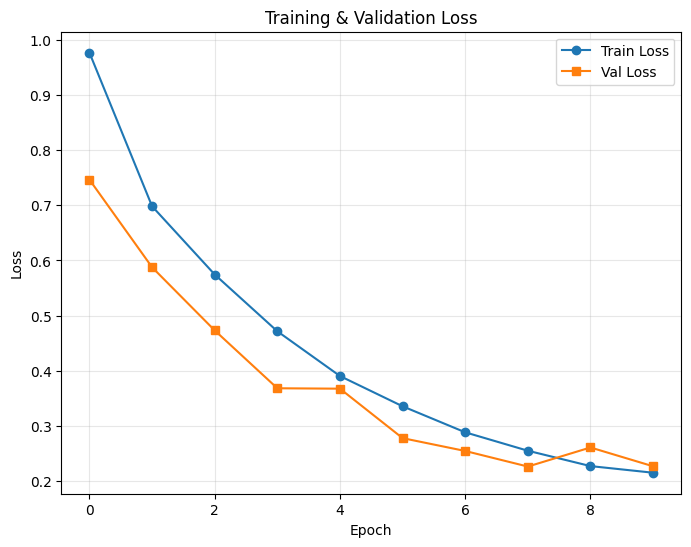

Saved: /content/MLDL_FloodDetection/results/loss_curve.png


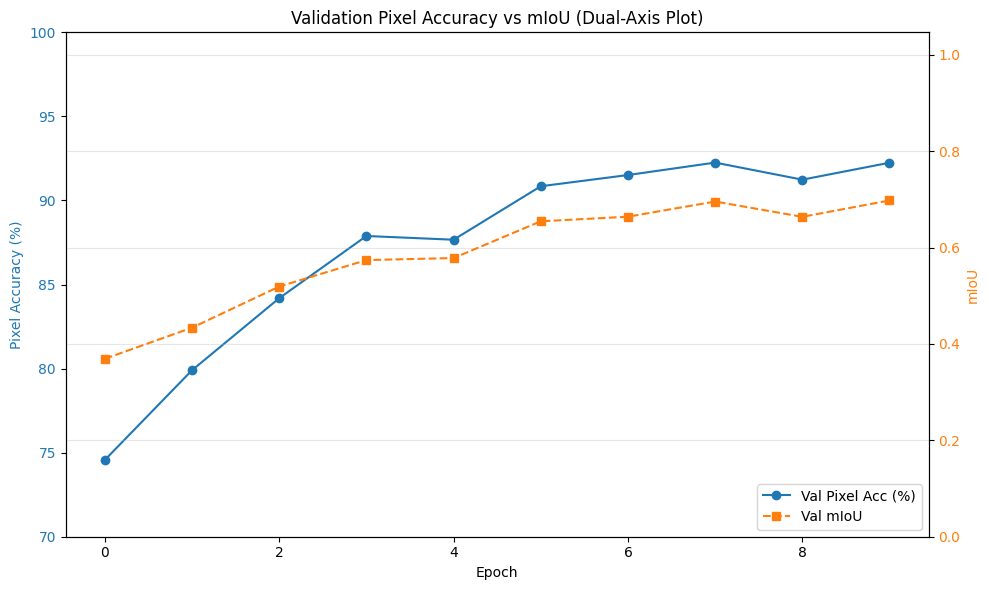

Saved: /content/MLDL_FloodDetection/results/accuracy_miou_curve.png


In [25]:
# ============================================================
# STEP 7 — TRAIN LOOP WITH LOSS, ACC, mIoU  [Week 2-3, 4-5]
# ============================================================
EPOCHS = 10
train_losses, val_losses = [], []
val_accs, val_mious = [], []

for epoch in range(EPOCHS):
    # ----------------------------
    # TRAINING
    # ----------------------------
    model.train()
    total_train_loss = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)               # (B, C, H, W)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # ----------------------------
    # VALIDATION
    # ----------------------------
    model.eval()
    total_val_loss = 0
    total_acc = 0
    total_iou = 0
    batches = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, masks)
            total_val_loss += loss.item()

            # Evaluate metrics
            preds = torch.argmax(outputs, dim=1)
            total_acc += pixel_accuracy(preds, masks)
            total_iou += iou_score(preds, masks, num_classes)

            batches += 1

    avg_val_loss = total_val_loss / len(val_loader)
    avg_acc = total_acc / batches
    avg_miou = total_iou / batches

    # Save for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accs.append(avg_acc)
    val_mious.append(avg_miou)

    # Print summary for each epoch
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f}")
    print(f"Val Acc:    {avg_acc*100:.2f}%")
    print(f"Val mIoU:   {avg_miou:.4f}")


# ============================================================
# SAVE LOSS CURVES
# ============================================================
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Val Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(alpha=0.3)

loss_curve_path = os.path.join(RESULTS_DIR, "loss_curve.png")
plt.savefig(loss_curve_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", loss_curve_path)


# ============================================================
# SAVE ACCURACY vs mIoU (Dual Axis)
# ============================================================
epochs = np.arange(len(val_accs))
fig, ax1 = plt.subplots(figsize=(10,6))

# LEFT AXIS → Pixel Accuracy
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Pixel Accuracy (%)", color="tab:blue")
ax1.plot(epochs, [x*100 for x in val_accs], color="tab:blue", marker="o", label="Val Pixel Acc (%)")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.set_ylim(70, 100)

# RIGHT AXIS → mIoU
ax2 = ax1.twinx()
ax2.set_ylabel("mIoU", color="tab:orange")
ax2.plot(epochs, val_mious, color="tab:orange", marker="s", linestyle="--", label="Val mIoU")
ax2.tick_params(axis='y', labelcolor="tab:orange")
ax2.set_ylim(0, max(val_mious) * 1.5 + 1e-6)

plt.title("Validation Pixel Accuracy vs mIoU (Dual-Axis Plot)")

# Merged legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="lower right")

plt.grid(alpha=0.3)
plt.tight_layout()

acc_iou_path = os.path.join(RESULTS_DIR, "accuracy_miou_curve.png")
plt.savefig(acc_iou_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", acc_iou_path)


Saved confusion matrix to: /content/MLDL_FloodDetection/results/confusion_matrix.png


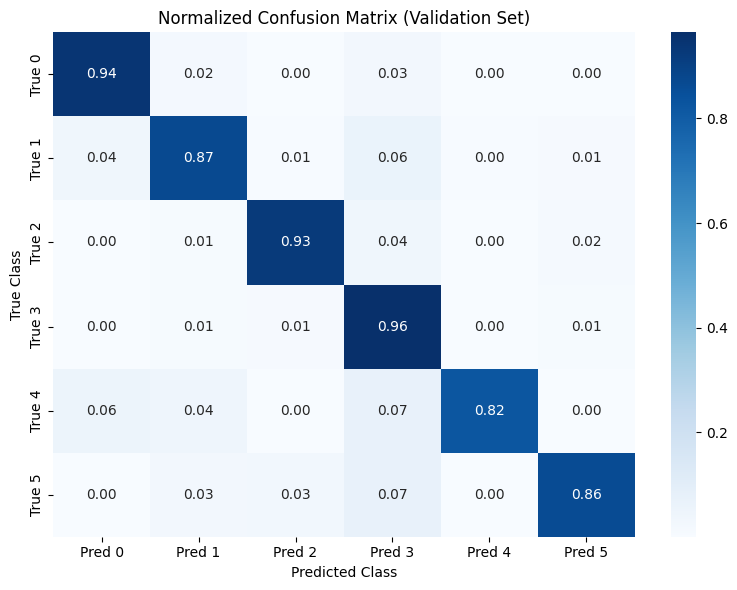

In [26]:
# ============================================================
# STEP 8 — Confusion Matrix
# ============================================================
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def compute_confusion_matrix(model, loader, num_classes):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy().flatten())
            all_targets.append(masks.cpu().numpy().flatten())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    cm = confusion_matrix(all_targets, all_preds, labels=list(range(num_classes)))
    return cm

# Compute confusion matrix
cm = compute_confusion_matrix(model, val_loader, num_classes)

# Normalize rows
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm, annot=True, cmap="Blues", fmt=".2f",
    xticklabels=[f"Pred {i}" for i in range(num_classes)],
    yticklabels=[f"True {i}" for i in range(num_classes)]
)
plt.title("Normalized Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()


cm_path = os.path.join(RESULTS_DIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
print("Saved confusion matrix to:", cm_path)

plt.show()


In [27]:
# ============================================================
# STEP 9 — FINAL EVALUATION (Per-class Precision/Recall)
#          [Week 4-5: Experimentation + Evaluation]
# ============================================================
def per_class_precision_recall(model, loader, num_classes):
    model.eval()
    TP = np.zeros(num_classes, dtype=np.int64)
    FP = np.zeros(num_classes, dtype=np.int64)
    FN = np.zeros(num_classes, dtype=np.int64)

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            for c in range(num_classes):
                pred_c = (preds == c)
                tgt_c  = (masks == c)

                TP[c] += (pred_c & tgt_c).sum().item()
                FP[c] += (pred_c & ~tgt_c).sum().item()
                FN[c] += (~pred_c & tgt_c).sum().item()

    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)

    for c in range(num_classes):
        if TP[c] + FP[c] > 0:
            precision[c] = TP[c] / (TP[c] + FP[c])
        else:
            precision[c] = np.nan
        if TP[c] + FN[c] > 0:
            recall[c] = TP[c] / (TP[c] + FN[c])
        else:
            recall[c] = np.nan

    return precision, recall

prec, rec = per_class_precision_recall(model, val_loader, num_classes)

print("\nPer-class Precision & Recall (Validation):")
for c in range(num_classes):
    print(f"Class {c}: Precision={prec[c]:.3f}, Recall={rec[c]:.3f}")

print(f"\nMacro Precision: {np.nanmean(prec):.3f}")
print(f"Macro Recall:    {np.nanmean(rec):.3f}")
print(f"Best Val Pixel Acc: {max(val_accs)*100:.2f}%")
print(f"Best Val mIoU:      {max(val_mious):.4f}")


Per-class Precision & Recall (Validation):
Class 0: Precision=0.913, Recall=0.942
Class 1: Precision=0.951, Recall=0.872
Class 2: Precision=0.754, Recall=0.927
Class 3: Precision=0.933, Recall=0.965
Class 4: Precision=0.949, Recall=0.822
Class 5: Precision=0.796, Recall=0.864

Macro Precision: 0.883
Macro Recall:    0.899
Best Val Pixel Acc: 92.25%
Best Val mIoU:      0.6976


Saved: /content/MLDL_FloodDetection/results/prediction_sample_1.png


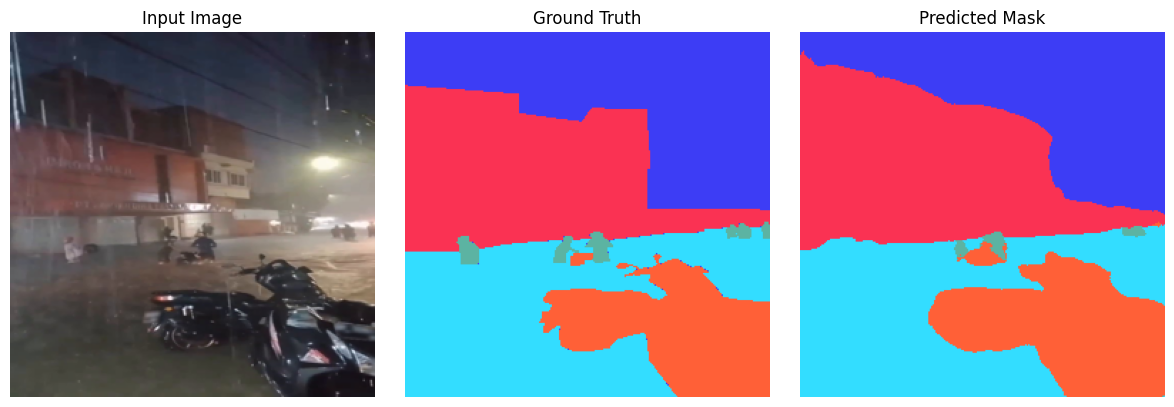

Saved: /content/MLDL_FloodDetection/results/prediction_sample_2.png


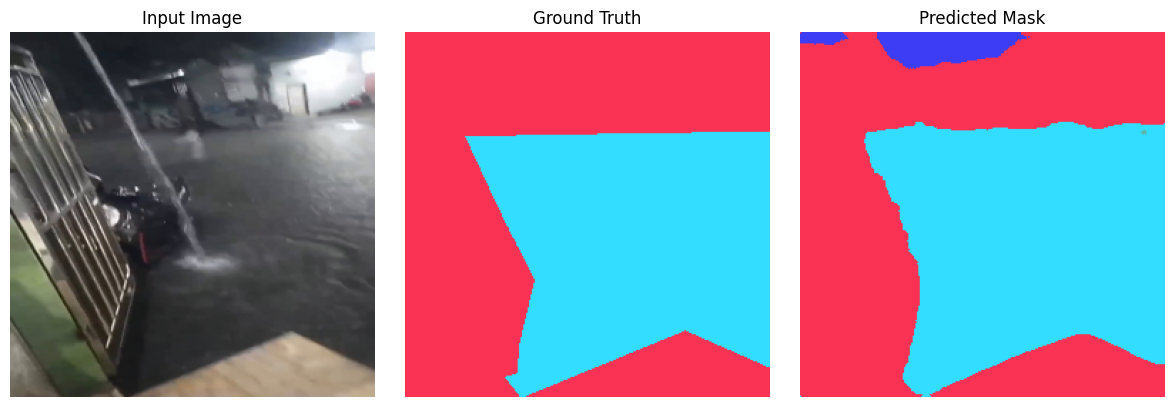

Saved: /content/MLDL_FloodDetection/results/prediction_sample_3.png


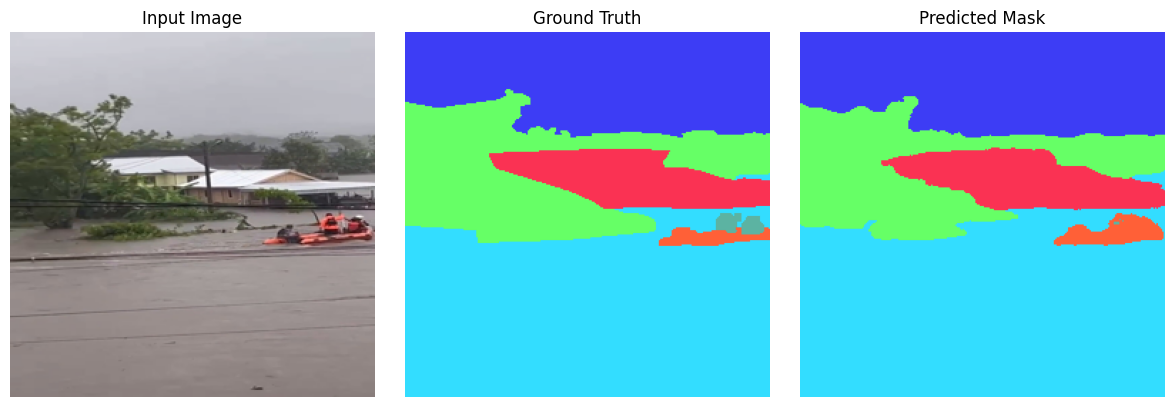

In [29]:
# ============================================================
# STEP 10 — VISUALIZE PREDICTIONS (Qualitative Results)
# ============================================================
model.eval()
imgs, masks = next(iter(val_loader))
imgs = imgs.to(device)

with torch.no_grad():
    logits = model(imgs)
    preds = torch.argmax(logits, dim=1).cpu()

imgs_np = imgs.cpu().permute(0,2,3,1).numpy()
masks_np = masks.numpy()
preds_np = preds.numpy()

# Loop through first 3 samples and save each grid image
for i in range(min(3, imgs_np.shape[0])):

    fig = plt.figure(figsize=(12, 4))

    # Input image
    ax1 = fig.add_subplot(1, 3, 1)
    img_show = (imgs_np[i] * [0.229,0.224,0.225] + [0.485,0.456,0.406])
    img_show = np.clip(img_show, 0, 1)
    ax1.imshow(img_show)
    ax1.set_title("Input Image")
    ax1.axis("off")

    # Ground truth mask
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(decode_mask(masks_np[i]))
    ax2.set_title("Ground Truth")
    ax2.axis("off")

    # Predicted mask
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(decode_mask(preds_np[i]))
    ax3.set_title("Predicted Mask")
    ax3.axis("off")

    plt.tight_layout()

    # Save BEFORE show()
    save_path = os.path.join(RESULTS_DIR, f"prediction_sample_{i+1}.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print("Saved:", save_path)

    plt.show()
